# Fitting a Line Using MCMC
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 30)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (Hint: this section is identical to the previous notebook.)

In [4]:
N = 200  # number of points
m = 8.  # slope
b = 29.  # intercept
sigma = 1.5  # scatter

rng = np.random.default_rng()
x =  rng.uniform(0, 1, N) # complete with random values between 0 and 1
y = (m * x) + b + rng.normal(0, sigma, size = N) # equation for a line PLUS random values from a Gaussian centered at 0 with standard deviation `sigma`
dy = np.repeat(sigma, N)  # array of error bars for all the data (all `sigma`)

## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range. (Hint: this section is identical to the previous notebook.)

In [31]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

def log_prior(theta):
    if m_min < m < m_max:
        Pm = 1 / m
    else:
        Pm = 0
    if b_min < b < b_max:
        Pb = 1 / b
    else:
        Pb = 0
    Ptot = Pm * Pb
    lnprior = np.log(Ptot)
    return lnprior

def log_likelihood(theta, x, y, dy):
    m, b = theta
    ymod = m * x + b
    chisq = (y - ymod) ** 2 / dy ** 2
    lnlikelihood = -0.5 * np.sum(chisq)
    return lnlikelihood

def log_posterior(theta, x, y, dy):
    lnposterior = log_prior(theta) + log_likelihood(theta, x, y, dy)
    return lnposterior

## Set Up the Ensemble Sampler
This time we will use the `emcee` package that you imported above to sample the posterior probability distribution. Everything you need is contained within the `emcee.EnsembleSampler` class. Initialize this with 100 walkers and the `log_posterior` function you defined above. Don't forget that `log_posterior` takes additional arguments `x`, `y`, and `dy`. (Hint: check the documentation for `EnsembleSampler` for how to deal with this.)

Note, we will initialise the sampler in #1.5

In [28]:
n_walkers = 100
n_params =  2
args = [x, y, dy]

## Setup random initial guesses for the starting positions

You'll need to give initial guesses for each walker, which you can draw randomly from the prior. 

In [29]:
m_random = rng.uniform(m_min, m_max, size = n_walkers)
b_random = rng.uniform(b_min, b_max, size = n_walkers)
initial_guesses = np.array([m_random, b_random]).T

## Initialize and run!

Initialize the `EnsembleSampler` object and then run it with the `run_mcmc` method. For now, 10000 steps is more than enough, and should run in less than a minute on your laptop. If this command takes too long, ask for help.

In [34]:
# initialize the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=args)

# run!
sampler.run_mcmc(initial_guesses, 500, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 601.96it/s]


State([[ 8.33900609 28.81921581]
 [ 7.81201513 28.96075932]
 [ 8.46327479 28.64197501]
 [ 8.18694339 28.86241777]
 [ 8.33469529 28.92151734]
 [ 8.45847747 28.69072081]
 [ 8.36111165 28.98108374]
 [ 8.41909906 28.93328211]
 [ 8.64782523 28.61336761]
 [ 8.17809926 28.71452611]
 [ 8.18106871 28.69342229]
 [ 7.78640703 29.19398943]
 [ 7.92490179 28.99323258]
 [ 7.89460653 28.87789748]
 [ 8.54692538 28.64156743]
 [ 8.28997419 28.8514642 ]
 [ 8.07989544 28.76381609]
 [ 9.18136633 28.39942621]
 [ 9.11080927 28.39177   ]
 [ 8.02705203 28.94034901]
 [ 8.27355303 28.77152079]
 [ 8.65610748 28.8705614 ]
 [ 8.44188903 28.60616598]
 [ 8.56071172 28.57411224]
 [ 8.45163874 28.76996164]
 [ 8.27088532 28.72534591]
 [ 8.41495904 28.90904101]
 [ 8.1492201  28.87092314]
 [ 8.36647049 28.76620593]
 [ 8.47575713 28.71522616]
 [ 7.94812225 28.76099744]
 [ 7.89203961 28.9785082 ]
 [ 8.38000266 29.02413968]
 [ 8.0010975  28.80594675]
 [ 8.78920727 28.54338668]
 [ 8.26472473 28.8492687 ]
 [ 8.34016236 28.70697

## Plot the Results
First make a plot of the walker positions (value of each parameter) at each step. Write a function to do this, since you'll be using it a lot.

(100, 500, 2)


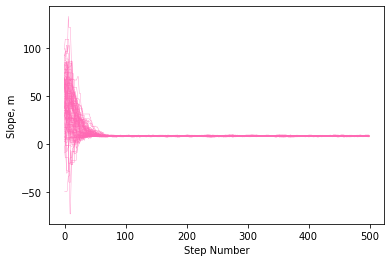

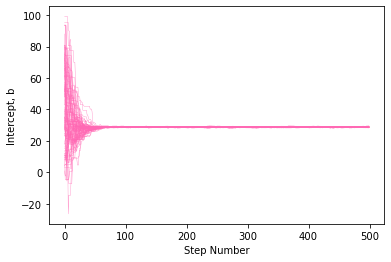

In [50]:
print(sampler.chain.shape)  # check that this has dimensions (n_walkers, n_steps, n_params)

def chain_plots(chain, **kwargs):
    """
    Plot the histories for each walker in sampler.chain
    
    Parameters
    ----------
    chain: ndarray
        3D array given by sampler.flatchain, with shape (n_walkers, n_steps, n_params)
    kwargs: `.Line2D` properties, optional
        All keyword arguments are passed to `pyplot.plot`
    """
    
    plt.figure()
    plt.plot(chain[:, :, 0].T, **kwargs, color = 'hotpink', linewidth = 0.3)
    plt.xlabel('Step Number')
    plt.ylabel('Slope, m')

    plt.figure()
    plt.plot(chain[:, :, 1].T, **kwargs, color = 'hotpink', linewidth = 0.3)
    plt.xlabel('Step Number')
    plt.ylabel('Intercept, b')
    
chain_plots(sampler.chain)

Each one of those colored lines is a walker. They started out at your initial guesses. What do you immediately notice?

Try making more useful plots by zooming in on the relevant parts. Hint: you can adjust line opacity in matplotlib with the `alpha` parameter.

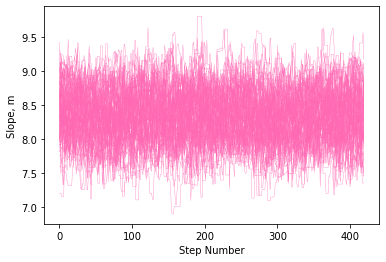

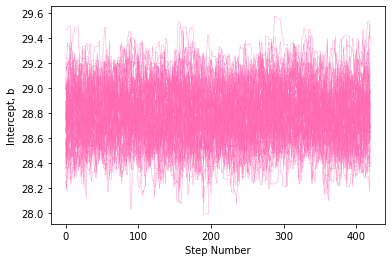

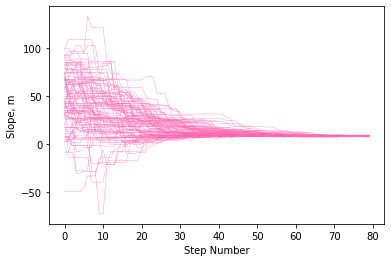

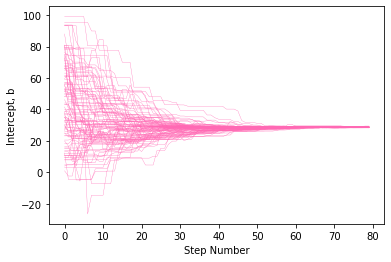

In [69]:
n_burn =  80
chain_plots(sampler.chain[:, n_burn:, :])
chain_plots(sampler.chain[:, :n_burn, :])

Are your chains converged? How many steps did it take for this to happen? This is called the "burn-in" period. **From now on, only use the steps after the burn-in period.**

Now make a scatter plot of the two parameters, one point for each walker-step. Hint: `sampler.flatchain`.

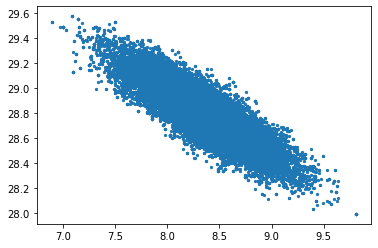

In [70]:
flat_samples = sampler.get_chain(discard = n_burn, flat = True)

plt.scatter(flat_samples[:, 0], flat_samples[:, 1], s = 5)

How does this compare to the distribution you had in the previous notebook (assuming you used the same parameters)?

Now let's marginalize over each parameter. Given that we have walkers that are distributed according to the 2D posterior, think about how to calculate the marginalized posterior for each parameter.

(array([0.00114986, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00344959]),
 array([-26.39231684, -26.37489558, -26.35747432, ...,  99.21499361,
         99.23241487,  99.24983613]),
 [<matplotlib.patches.Polygon at 0x7f7c6acf8a30>])

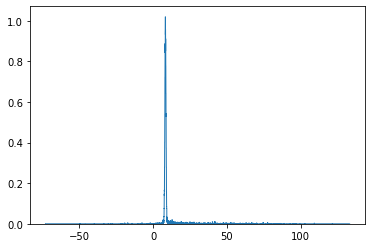

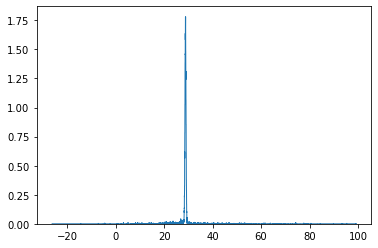

In [76]:
plt.figure()
plt.hist(sampler.flatchain[n_burn:, 0], bins = 'auto', histtype = 'step', density = True)

plt.figure()
plt.hist(sampler.flatchain[n_burn:, 1], bins = 'auto', histtype = 'step', density = True)

Calculate the medians and the 68% ($1\sigma$) confidence intervals for each parameter. Check your answers against the centers and widths of the distributions you just plotted above. Do they look about right?

In [80]:
m_low, m_med, m_high = np.percentile(sampler.flatchain[n_burn:, 0], (25, 50, 75))
dm_lo = m_low - m_med
dm_hi = m_high - m_med
print(f'$m = {m_med:.2f}_{{{dm_lo:+.2f}}}^{{{dm_hi:+.2f}}}$')

b_low, b_med, b_high = np.percentile(sampler.flatchain[n_burn:, 1], (25, 50, 75))
db_lo = b_low - b_med
db_hi = b_high - b_med
print(f'$b = {b_med:.2f}_{{{db_lo:+.2f}}}^{{{db_hi:+.2f}}}$')

$m = 8.39_{-0.28}^{+0.30}$
$b = 28.79_{-0.16}^{+0.16}$


There's an easy way to generate all these plots and summary statistics: `corner.corner`! Produce a corner plot with the true parameters labeled and the best-fit values (with error bars) printed on the plot. How close did we get to the parameters we used to generate the data?

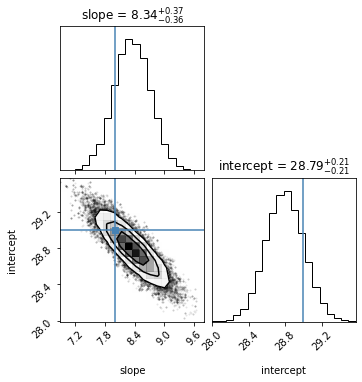

In [82]:
corner.corner(sampler.flatchain[n_burn * n_walkers:], 
              labels = ['slope', 'intercept'], 
              truths = [m, b], show_titles = True);

## Take-Away Message
MCMC is a much more efficient way to sample the probability distribution because the walkers mostly stay in the highest-probability region. Plus it essentially gives you the marginalized posteriors for free, because the density of walkers matches the probability density.

## Other Things to Try
- Add a parameter for the intrinsic scatter and redo the MCMC fit.
- Try implementing Metropolis-Hastings algorithm yourself and see if you can get the same results as `emcee`.